# Threshold for $F_1$ score calculation
---
The optimal threshold for converting the probabilities obtained after classification -- as returned by the sigmoid activation function -- to labels (0 are 1) is determined using a simple procedure. First, the training dataset is divided into equal sets. Then, for each set, the $F_1$ score is calculated for various threshold and box/violin plots are built. 


## 1. Load Tensors and Targets

The training, validation and test tensors along with the associated targets are loaded.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from common import *

%matplotlib inline

bottleneck_features = np.load('data/bottleneck_features/yelp_resnet50_50k.npz')

X_train = bottleneck_features['train_features'].reshape(50000,2048)
X_valid = bottleneck_features['valid_features'].reshape(5000,2048)
X_test  = bottleneck_features['test_features'].reshape(5000,2048)

y_train = bottleneck_features['train_targets']
y_valid = bottleneck_features['valid_targets']
y_test  = bottleneck_features['test_targets']

Using TensorFlow backend.


## 2. Features scaling

The features are standardized by removing the mean and scaling to unit variance. The scaler is first derived on the training data and then applied on the training, validation and test data.

In [2]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

del X_train, X_valid, X_test

## 3. Principal Component Analysis

A principal component analysis (PCA) is carried out. See this [notebook](xgboost.ipynb) for details.

In [3]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True)
pca.fit(X_train_scaled)

X_train_reduced = pca.transform(X_train_scaled)
X_valid_reduced = pca.transform(X_valid_scaled)
X_test_reduced = pca.transform(X_test_scaled)

del X_train_scaled, X_valid_scaled, X_test_scaled

## 4. Parameters of the Test

The training/validation/test sets re divided into 50 samples. The threshold span from 0.25 to 0.75 by steps of 0.05. 

In [4]:
size_train = 1000
bins_train = range(0, 50000, size_train)

size_valid = size_train//10
bins_valid = range(0, 5000, size_valid)
bins_test = bins_valid

threshold = [x/100. for x in range(25,75,5)]

## 5. Classification with XGBoost

The XGBoost model is used for classification. The parameters used in this [notebook](xgboost.ipynb) are used. The $F_1$score for each couple (sample,threshold) are printed and stored in a table.

In [5]:
import xgboost as xgb

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.015
param['max_depth'] = 10
param['subsample'] = 0.5
param['eval_metric'] = 'logloss'
param['colsample_bytree'] = 0.3
param['nthread'] = 4

num_round = 500

y_hat = np.array([[0]*9]*(size_valid), dtype=np.float32)
f1_scores_ovr = np.array([[0]*len(bins_train)]*len(threshold), dtype=np.float32)

for s in range(0,len(bins_train)):
    for l in range(9):
        xg_train = xgb.DMatrix(X_train_reduced[bins_train[s]:bins_train[s]+size_train], 
                               label=y_train[bins_train[s]:bins_train[s]+size_train,l])
        xg_valid = xgb.DMatrix(X_valid_reduced[bins_valid[s]:bins_valid[s]+size_valid], 
                               label=y_valid[bins_valid[s]:bins_valid[s]+size_valid,l])
        xg_test = xgb.DMatrix(X_test_reduced[bins_test[s]:bins_test[s]+size_valid], 
                              label=y_test[bins_test[s]:bins_test[s]+size_valid,l])

        eval_list = [(xg_train, 'train'),(xg_valid, 'valid')]
        model = xgb.train(param, xg_train, num_round, eval_list, verbose_eval=False, 
                          early_stopping_rounds=10)

        y_hat[:,l] = model.predict(xg_test)
    
    
    f1_scores_ovr[:,s] = [f1_score(y_test[bins_test[s]:bins_test[s]+size_valid,:], (y_hat >= t).astype(int)) 
                          for t in threshold]
    print("Sample %d/%d: F1 score =" % (s, len(bins_train)), f1_scores_ovr[:,s])

del xg_train, xg_valid, xg_test

Sample 0/50: F1 score = [ 0.73919755  0.75        0.75890636  0.75513697  0.75942552  0.72888017
  0.702407    0.66117644  0.62626261  0.5888738 ]
Sample 1/50: F1 score = [ 0.73798448  0.745004    0.74959081  0.73909324  0.74007219  0.71428573
  0.68596882  0.65384614  0.6041131   0.54469275]
Sample 2/50: F1 score = [ 0.70145816  0.70109546  0.71071714  0.7085427   0.71299636  0.69484538
  0.63145542  0.58611828  0.56790125  0.52478135]
Sample 3/50: F1 score = [ 0.67417538  0.6906957   0.70123023  0.70631289  0.71119845  0.68490154
  0.65577888  0.62585032  0.57720059  0.52950078]
Sample 4/50: F1 score = [ 0.69068128  0.6963563   0.6970464   0.70785522  0.70075756  0.67232239
  0.62588233  0.57697284  0.50218976  0.40000001]
Sample 5/50: F1 score = [ 0.73323172  0.74079877  0.74354839  0.75407028  0.73076922  0.68872803
  0.65988702  0.61519903  0.58748406  0.54297405]
Sample 6/50: F1 score = [ 0.7415902   0.7480315   0.75468624  0.75767916  0.74683547  0.72289157
  0.68201756  0.63905

## 6. Results

The box and violin plots are plotted.

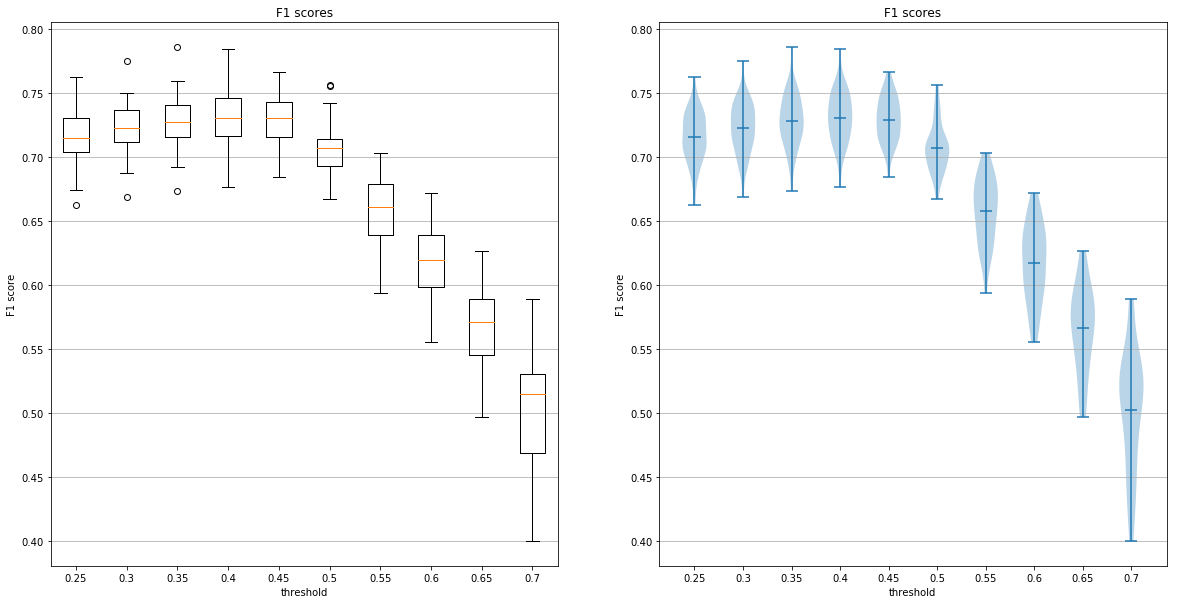

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# box plot
axes[0].boxplot(list(f1_scores_ovr))
axes[0].set_title('F1 scores')

# violin plot
axes[1].violinplot(list(f1_scores_ovr), showmeans=True, showmedians=False)
axes[1].set_title('F1 scores')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(threshold))])
    ax.set_xlabel('threshold')
    ax.set_ylabel('F1 score')
    ax.set_xticklabels(map(str,threshold))
    

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(threshold))])
plt.show()